In [1]:
import os

from Bio import SeqIO
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

METADATA_DIR = "Metadata"
SEQUENCES_DIR = "Sequences"
PLOTS_DIR = os.path.join("..", "Output")

REFERENCE = 'EPI_ISL_402125'

NUCLEOTIDE_AMBIGUITY = ('Y', 'R', 'W', 'S', 'K', 'M', 'V', 'D', 'B', 'H', 'N', '-', 'I')

In [2]:
metadata = pd.read_csv(os.path.join(METADATA_DIR, "SARS_CoV_2.csv"), index_col=0)
metadata['date'] = pd.to_datetime(metadata['date'], errors="coerce")

In [3]:
metadata

,region_exposure,country_exposure,date,host,pangolin_lineage,Nextstrain_clade,GISAID_clade
gisaid_epi_isl,,,,,,,
EPI_ISL_754239,Asia,Indonesia,2020-07-20,Human,B,19A,O
EPI_ISL_815257,Europe,Albania,2020-09-05,Human,B.1.236,20A,G
EPI_ISL_418241,Africa,Algeria,2020-03-02,Human,B.1,20C,GH
EPI_ISL_418242,Africa,Algeria,2020-03-08,Human,B.1,20C,GH
EPI_ISL_420037,Africa,Algeria,2020-03-02,Human,B.1,20C,GH
...,...,...,...,...,...,...,...
EPI_ISL_566039,North America,USA,2020-04-04,Panthera tigris jacksoni,B.1,20C,GH
EPI_ISL_566041,North America,USA,2020-04-04,Panthera tigris jacksoni,B.1,20C,GH
EPI_ISL_566042,North America,USA,2020-04-04,Panthera tigris jacksoni,B.1,20C,GH


# Mutation on amino acid level

In [4]:
nucleotide = SeqIO.index(os.path.join(SEQUENCES_DIR, "nucleotide.fasta"), "fasta")
nucleotideRef = nucleotide[REFERENCE]

In [5]:
polypeptide = SeqIO.index(os.path.join(SEQUENCES_DIR, "polypeptide.fasta"), "fasta")
polypeptideRef = polypeptide[REFERENCE]

In [6]:
df = []

for record in nucleotide.values():
    snpNum = sum(0 if base in NUCLEOTIDE_AMBIGUITY or ref == base else 1
                   for ref, base in zip(nucleotideRef, record))
    accession = record.id
    mutNum = sum(0 if base in ('X', '-') or ref == base else 1
                   for ref, base in zip(polypeptideRef, polypeptide[accession]))
    if record.id in metadata.index:
        df.append({
            "accession": accession,
            "clade": metadata.loc[accession, 'Nextstrain_clade'],
            "date": metadata.loc[accession, 'date'],
            "mutNum": mutNum,
            "snpNum": snpNum
        })

df = pd.DataFrame.from_dict(df)
df.loc[pd.isna(df['clade']), 'clade'] = "unknown"

In [7]:
badSeqs = df[df['snpNum'] >= 20000]['accession']

badSeqsRatio = []

for month, monthInfo in df.groupby(df['date'].dt.to_period("M")):
    badSeed = monthInfo['accession'].isin(badSeqs)
    clade = ",".join(set(monthInfo.loc[badSeed, "clade"]))
    badRatio = sum(badSeed) / len(monthInfo)
    if badRatio:
        badSeqsRatio.append({
            "month": month,
            "proportion": badRatio,
            "clades": clade
        })

badSeqsRatio = pd.DataFrame.from_dict(badSeqsRatio)
badSeqsRatio.set_index('month').to_csv(os.path.join(PLOTS_DIR, "proportion.tsv"), sep='\t')

In [8]:
noOutlier = df[df['snpNum'] < 20000]

In [9]:
isV1 = noOutlier['clade'].str.contains("501Y.V1")
isV2 = noOutlier['clade'].str.contains("501Y.V2")

N501Y_V1 = noOutlier[isV1]
N501Y_V2 = noOutlier[isV2]

nonN501Y = noOutlier[~(isV1 | isV2)]

In [10]:
len(nonN501Y['clade'].str.contains("501Y.")) + len(N501Y_V1) + len(N501Y_V2)

3823

In [11]:
len(noOutlier)

3823

In [12]:
colors = {
    "Other clades": "lightblue",
    "501Y V1": "red",
    "501Y V2": "yellow"
}

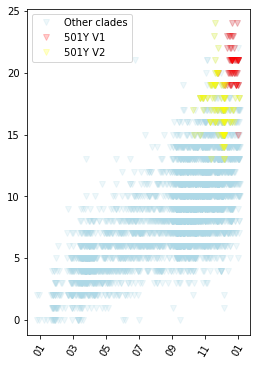

In [13]:
fig, ax = plt.subplots(figsize = (4, 6))

clade = "Other clades"
ax.plot_date(
    noOutlier['date'],
    noOutlier['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
clade = "501Y V1"
ax.plot_date(
    N501Y_V1['date'],
    N501Y_V1['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
clade = "501Y V2"
ax.plot_date(
    N501Y_V2['date'],
    N501Y_V2['mutNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
ax.tick_params(axis='x', labelrotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%m'))

plt.legend(loc='upper left')
plt.savefig(os.path.join(PLOTS_DIR, "mutation_count.pdf"))

plt.show()

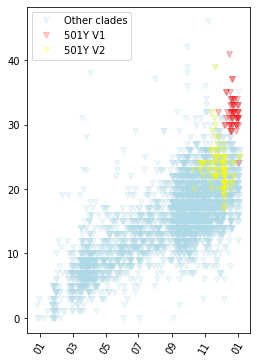

In [14]:
fig, ax = plt.subplots(figsize = (4, 6))

clade = "Other clades"
ax.plot_date(
    noOutlier['date'],
    noOutlier['snpNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
clade = "501Y V1"
ax.plot_date(
    N501Y_V1['date'],
    N501Y_V1['snpNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
clade = "501Y V2"
ax.plot_date(
    N501Y_V2['date'],
    N501Y_V2['snpNum'],
    alpha = 0.2,
    marker = 'v',
    color = colors[clade],
    label = clade
)
ax.tick_params(axis='x', labelrotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%m'))

plt.legend(loc='upper left')
plt.savefig(os.path.join(PLOTS_DIR, "snp_count.pdf"))

In [15]:
noOutlier[noOutlier['snpNum'] > 30].sort_values('date')

,accession,clade,date,mutNum,snpNum
99,EPI_ISL_431784,19A,2020-03-18,6,31
2337,EPI_ISL_605781,20B,2020-04-02,8,38
3647,EPI_ISL_718269,20B,2020-07-31,8,37
1699,EPI_ISL_569235,20A,2020-09-10,15,32
3713,EPI_ISL_682334,20B,2020-09-28,16,31
...,...,...,...,...,...
2951,EPI_ISL_792680,20B,2021-01-02,21,33
2949,EPI_ISL_792683,20B,2021-01-02,21,33
3000,EPI_ISL_779402,20I/501Y.V1,2021-01-02,21,32
2948,EPI_ISL_792681,20B,2021-01-02,22,35
